In [1]:
%matplotlib inline

# Section 2: Machine learning to predict age from rs-fmri

We will integrate what we've learned in the previous sections to extract data from rs-fmri images, and use that data as features in a machine learning model

The dataset consists of XXXX children (ages 3-13) and 33 young adults (ages 18-39). We will use rs-fmri data to try to predict who are adults and who are children.

#### Run the cell below to ready the confound preparation script

In [2]:
# Confounds function

import h5py
import numpy as np

def prepare_confounds(conf, key = 'R', transpose=True):
    arrays = {}
    f = h5py.File(conf)
    for k, v in f.items():
        arrays[k] = np.array(v)
    
    if transpose:
        output = arrays[key].T
    else:
        output = arrays[key]
    
    return output

/home/users/jvogel/anaconda2/envs/nilearn_tutorial/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Load the data


In [3]:
# if the data is already stored somewhere OR you want to store it somewhere, specify this here
wdir = '/data1/users/jvogel/nilearn_tutorial/MAIN_Nilearn/'

#wdir = None

In [4]:
# Now fetch the data
#data = fetch_data(None,data_dir=wdir)

from glob import glob
import os
data = sorted(glob(os.path.join(wdir,'*.nii.gz')))
confounds = sorted(glob(os.path.join(wdir,'*.mat')))

How many individual subjects do we have?

In [5]:
#len(data.func)
len(data)

155

### Get Y (our target) and assess its distribution

In [6]:
# Let's load the phenotype data
#data.phenotypic

pheno_path = '/data1/users/jvogel/nilearn_tutorial/MAIN_Nilearn/participants.tsv'

In [7]:
from pandas import read_csv

#pheno = read_csv(data.phenotypic)

pheno = read_csv(pheno_path, sep='\t')
pheno.head()

,participant_id,Age,AgeGroup,Child_Adult,Gender,Handedness,ToM Booklet-Matched,ToM Booklet-Matched-NOFB,FB_Composite,FB_Group,WPPSI BD raw,WPPSI BD scaled,KBIT_raw,KBIT_standard,DCCS Summary,Scanlog: Scanner,Scanlog: Coil,Scanlog: Voxel slize,Scanlog: Slice Gap
0,sub-pixar001,4.774812,4yo,child,M,R,0.8,0.736842105,6,pass,22,13,n/a,n/a,3,3T1,7-8yo 32ch,3mm iso,0.1
1,sub-pixar002,4.856947,4yo,child,F,R,0.72,0.736842105,4,inc,18,9,n/a,n/a,2,3T1,7-8yo 32ch,3mm iso,0.1
2,sub-pixar003,4.153320,4yo,child,F,R,0.44,0.421052632,3,inc,15,9,n/a,n/a,3,3T1,7-8yo 32ch,3mm iso,0.1
3,sub-pixar004,4.473648,4yo,child,F,R,0.64,0.736842105,2,fail,17,10,n/a,n/a,3,3T1,7-8yo 32ch,3mm iso,0.2
4,sub-pixar005,4.837782,4yo,child,F,R,0.6,0.578947368,4,inc,13,5,n/a,n/a,2,3T1,7-8yo 32ch,3mm iso,0.2


In [8]:
#### DEV: Subsamble children
ch_index = pheno[pheno.Child_Adult=='child'].index
ad_index = pheno[pheno.Child_Adult=='adult'].index
ch_selection = np.random.choice(ch_index, size=50, replace=False)
pheno = pheno.loc[ch_selection.tolist() + ad_index.tolist()]
data = [[y for y in data if x in y][0] for x in pheno.participant_id]

Looks like there is a column labeling children and adults. Let's capture it in a variable

In [9]:
y_ageclass = pheno['Child_Adult']
y_ageclass.head()

42     child
120    child
81     child
85     child
62     child
Name: Child_Adult, dtype: object

Maybe we should have a look at the distribution of our target variable

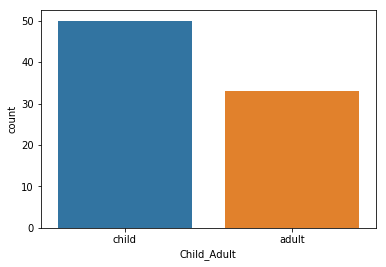

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.countplot(y_ageclass)

In [11]:
### We are a bit unbalanced -- there seems to be more children than adults
pheno.Child_Adult.value_counts()

child    50
adult    33
Name: Child_Adult, dtype: int64

### Extract features

Here, we are going to use the same techniques we learned in the previous tutorial to extract rs-fmri connectivity features from every subject.

How are we going to do that? With a for loop.

Don't worry, it's not as scary as it sounds

In [12]:
# Here is a really simple for loop

for i in range(10):
    print('the number is', i)

the number is 0
the number is 1
the number is 2
the number is 3
the number is 4
the number is 5
the number is 6
the number is 7
the number is 8
the number is 9


In [13]:
container = []
for i in range(10):
    container.append(i)

container

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

Now lets construct a more complicated loop to do what we want

First we do some things we don't need to do in the loop. Let's reload our atlas, and re-iniate our masker and correlation_measure

In [14]:
from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure
from nilearn import datasets

# load atlas
multiscale = datasets.fetch_atlas_basc_multiscale_2015()
atlas_filename = multiscale.scale064

# initialize masker (change verbosity)
masker = NiftiLabelsMasker(labels_img=atlas_filename, standardize=True, 
                           memory='nilearn_cache', verbose=0)

# initialize correlation measure, set to vectorize
correlation_measure = ConnectivityMeasure(kind='correlation', vectorize=True,
                                         discard_diagonal=True)

/home/users/jvogel/anaconda2/envs/nilearn_tutorial/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/users/jvogel/anaconda2/envs/nilearn_tutorial/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [15]:
vectorized = ConnectivityMeasure(kind='correlation', vectorize=True, discard_diagonal=True)
not_vectorized = ConnectivityMeasure(kind='correlation', vectorize=False)

In [16]:
# example
#sub = data.func[0]
sub = data[0]
#conf = prepare_confounds(data.confounds[0])
conf = prepare_confounds(confounds[0])
time_series = masker.fit_transform(sub, confounds=conf)
v_corr = vectorized.fit_transform([time_series])[0]
nv_corr = not_vectorized.fit_transform([time_series])[0]

print('vectorized:', v_corr.shape)
print('not vectorized:', nv_corr.shape)

/home/users/jvogel/anaconda2/envs/nilearn_tutorial/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


vectorized: (2016,)
not vectorized: (64, 64)


In [17]:
# nfeat = 
# nfeat * (nfeat-1) / 2

Okay -- now that we have that cleared up, let's run our big loop!

**NOTE**: On a laptop, this might take quite some time.

**Maybe don't run it right now!**

In [19]:
all_features = [] # here is where we will put the data (a container)

for i,sub in enumerate(data):
    # convert confounds to readable format
    conf = prepare_confounds(confounds[i])
    # extract the timeseries from the ROIs in the atlas
    time_series = masker.fit_transform(sub, confounds=conf)
    # create a region x region correlation matrix
    correlation_matrix = correlation_measure.fit_transform([time_series])[0]
    # add to our container
    all_features.append(correlation_matrix)
    # keep track of status
    print('finished %s of %s'%(i+1,len(data)))

finished 1 of 83
finished 2 of 83
finished 3 of 83
finished 4 of 83
finished 5 of 83
finished 6 of 83
finished 7 of 83
finished 8 of 83
finished 9 of 83
finished 10 of 83
finished 11 of 83
finished 12 of 83
finished 13 of 83
finished 14 of 83
finished 15 of 83
finished 16 of 83
finished 17 of 83
finished 18 of 83
finished 19 of 83
finished 20 of 83
finished 21 of 83
finished 22 of 83
finished 23 of 83
finished 24 of 83
finished 25 of 83
finished 26 of 83
finished 27 of 83
finished 28 of 83
finished 29 of 83
finished 30 of 83
finished 31 of 83
finished 32 of 83
finished 33 of 83
finished 34 of 83
finished 35 of 83
finished 36 of 83
finished 37 of 83
finished 38 of 83
finished 39 of 83
finished 40 of 83
finished 41 of 83
finished 42 of 83
finished 43 of 83
finished 44 of 83
finished 45 of 83
finished 46 of 83
finished 47 of 83
finished 48 of 83
finished 49 of 83
finished 50 of 83
finished 51 of 83
finished 52 of 83
finished 53 of 83
finished 54 of 83
finished 55 of 83
finished 56 of 83
f

In [20]:
# Let's save the data to disk

# np.savez_compressed('BASC064_features',a = all_features, b = full_y)
np.savez_compressed('MAIN_BASC064_subsamp_features',a = all_features, b = y_ageclass)

In case you do not want to run the full loop on your computer, you can load the output of the loop here!

In [21]:
#feat_file = 'BASC064_features.npz'
feat_file = 'MAIN_BASC064_subsamp_features.npz'
X_features = np.load(feat_file)['a']

In [22]:
X_features.shape

(83, 2016)

Okay so we've got our features.

We can visualize our feature matrix

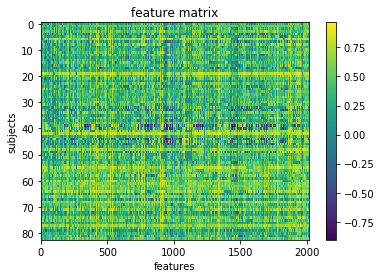

In [23]:
plt.imshow(X_features, aspect='auto')
plt.colorbar()
plt.title('feature matrix')
plt.xlabel('features')
plt.ylabel('subjects')

### Prepare data for machine learning

Here, we will define a "training sample" where we can play around with our models. We will also set aside a "test" sample that we will not touch until the end

We want to be sure that our training and test sample are matched! We can do that with a "stratified split". Specifically, we will stratify by age group.

In [24]:
from sklearn.model_selection import train_test_split

# Split the sample to training/test with a 60/40 ratio, and 
# stratify by age group, and also shuffle the data.

X_train, X_test, y_train, y_test = train_test_split(
                                                    X_features, # x
                                                    y_ageclass, # y
                                                    test_size = 0.4, # 60%/40% split  
                                                    shuffle = True, # shuffle dataset
                                                                    # before splitting
                                                    stratify = y_ageclass, # keep
                                                                           # distribution
                                                                           # of ageclass
                                                                           # consistent
                                                                           # betw. train
                                                                           # & test sets.
                                                    random_state = 123 # same shuffle each
                                                                       # time
                                                                       )

# print the size of our training and test groups
print('training:', len(X_train),
     'testing:', len(X_test))

training: 49 testing: 34


Let's visualize the distributions to be sure they are matched

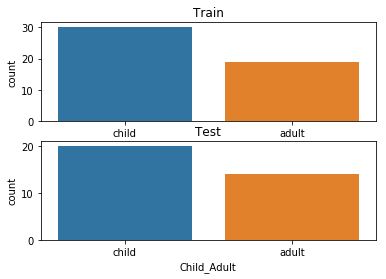

In [25]:
fig,(ax1,ax2) = plt.subplots(2)
sns.countplot(y_train, ax=ax1, order=['child','adult'])
ax1.set_title('Train')
sns.countplot(y_test, ax=ax2, order=['child','adult'])
ax2.set_title('Test')

### Run your first model!

Machine learning can get pretty fancy pretty quickly. We'll start with a very standard classification model called a Support Vector Classifier (SVC). 

While this may seem unambitious, simple models can be very robust. And we don't have enough data to create more complex models.

For more information, see this excellent resource:
https://hal.inria.fr/hal-01824205

Let's fit our first model!

In [26]:
from sklearn.svm import SVC
l_svc = SVC(kernel='linear') # define the model

l_svc.fit(X_train, y_train) # fit the model

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Well... that was easy. Let's see how well the model learned the data!

We can judge our model on several criteria:
* Accuracy: The proportion of predictions that were correct overall.
* Precision: Accuracy of cases predicted as positive
* Recall: Number of true positives correctly predicted to be positive
* f1 score: A balance between precision and recall

In [27]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, f1_score

# predict the training data based on the model
y_pred = l_svc.predict(X_train) 

# caluclate the model accuracy
acc = l_svc.score(X_train, y_train) 

# calculate the model precision, recall and f1, all in one convenient report!
cr = classification_report(y_true=y_train,
                      y_pred = y_pred)

# get a table to help us break down these scores
cm = confusion_matrix(y_true=y_train, y_pred = y_pred) 


Let's view our results and plot them all at once!

accuracy: 1.0
             precision    recall  f1-score   support

      adult       1.00      1.00      1.00        19
      child       1.00      1.00      1.00        30

avg / total       1.00      1.00      1.00        49



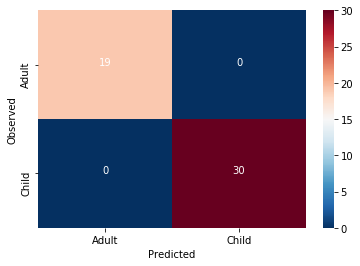

In [29]:
import itertools
from pandas import DataFrame

# print results
print('accuracy:', acc)
print(cr)

# plot confusion matrix
cmdf = DataFrame(cm, index = ['Adult','Child'], columns = ['Adult','Child'])
sns.heatmap(cmdf, cmap = 'RdBu_r')
plt.xlabel('Predicted')
plt.ylabel('Observed')
# label cells in matrix
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j+0.5, i+0.5, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white")

HOLY COW! Machine learning is amazing!!! Almost a perfect fit!

...which means there's something wrong. What's the problem here?

In [30]:
from sklearn.model_selection import cross_val_predict, cross_val_score

# predict
y_pred = cross_val_predict(l_svc, X_train, y_train, 
                           groups=y_train, cv=10)
# scores
acc = cross_val_score(l_svc, X_train, y_train, 
                     groups=y_train, cv=10)

We can look at the accuracy of the predictions for each fold of the cross-validation

In [31]:
for i in range(10):
    print('Fold %s -- Acc = %s'%(i, acc[i]))
#list(zip(range(10),acc))

Fold 0 -- Acc = 1.0
Fold 1 -- Acc = 1.0
Fold 2 -- Acc = 0.8
Fold 3 -- Acc = 1.0
Fold 4 -- Acc = 0.6
Fold 5 -- Acc = 1.0
Fold 6 -- Acc = 1.0
Fold 7 -- Acc = 0.8
Fold 8 -- Acc = 1.0
Fold 9 -- Acc = 1.0


We can also look at the overall accuracy of the model

In [32]:
from sklearn.metrics import accuracy_score
overall_acc = accuracy_score(y_pred = y_pred, y_true = y_train)
overall_cr = classification_report(y_pred = y_pred, y_true = y_train)
overall_cm = confusion_matrix(y_pred = y_pred, y_true = y_train)
print('Accuracy:',overall_acc)
print(overall_cr)


Accuracy: 0.9183673469387755
             precision    recall  f1-score   support

      adult       0.94      0.84      0.89        19
      child       0.91      0.97      0.94        30

avg / total       0.92      0.92      0.92        49



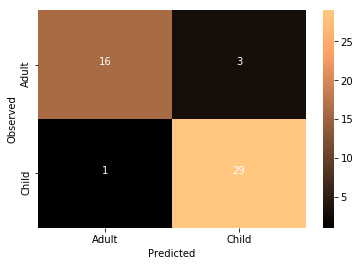

In [33]:
thresh = overall_cm.max() / 2
cmdf = DataFrame(overall_cm, index = ['Adult','Child'], columns = ['Adult','Child'])
sns.heatmap(cmdf, cmap='copper')
plt.xlabel('Predicted')
plt.ylabel('Observed')
for i, j in itertools.product(range(overall_cm.shape[0]), range(overall_cm.shape[1])):
        plt.text(j+0.5, i+0.5, format(overall_cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white")

Not too bad at all! But what are some things you notice about our results?

### Tweak your model

It's very important to learn when and where its appropriate to "tweak" your model.

Since we have done all of the previous analysis in our training data, it's find to try different models. But we **absolutely cannot** "test" it on our left out data. If we do, we are in great danger of overfitting.

We could try other models, or tweak hyperparameters, but we are probably not powered sufficiently to do so, and would once again risk overfitting.


But as a demonstration, we could see the impact of "scaling" our data. Certain machine learning algorithms perform better when all the input data is transformed to a uniform range of values. This is often between 0 and 1, or mean centered around with unit variance. We can perhaps look at the performance of the model after scaling the data

In [49]:
# Scale the training data
from sklearn.preprocessing import MinMaxScaler
scaler = StandardScaler().fit(X_train)
X_train_scl = scaler.transform(X_train)

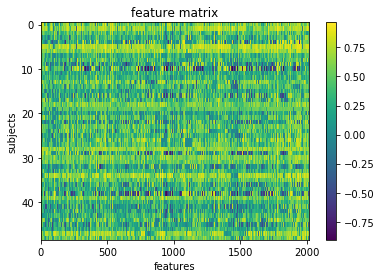

In [50]:
plt.imshow(X_train, aspect='auto')
plt.colorbar()
plt.title('Training Data')
plt.xlabel('features')
plt.ylabel('subjects')

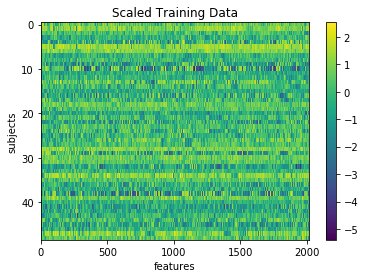

In [53]:
plt.imshow(X_train_scl, aspect='auto')
plt.colorbar()
plt.title('Scaled Training Data')
plt.xlabel('features')
plt.ylabel('subjects')

Accuracy: 0.9387755102040817
             precision    recall  f1-score   support

      adult       0.94      0.89      0.92        19
      child       0.94      0.97      0.95        30

avg / total       0.94      0.94      0.94        49



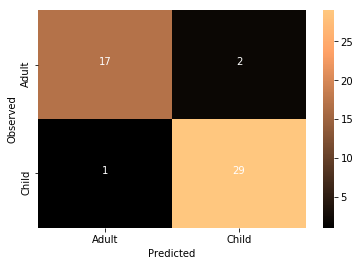

In [52]:
# repeat the steps above to re-fit the model 
# and assess its performance

# don't forget to switch X_train to X_train_scl

# predict
y_pred = cross_val_predict(l_svc, X_train_scl, y_train, 
                           groups=y_train, cv=10)

# get scores
overall_acc = accuracy_score(y_pred = y_pred, y_true = y_train)
overall_cr = classification_report(y_pred = y_pred, y_true = y_train)
overall_cm = confusion_matrix(y_pred = y_pred, y_true = y_train)
print('Accuracy:',overall_acc)
print(overall_cr)

# plot
thresh = overall_cm.max() / 2
cmdf = DataFrame(overall_cm, index = ['Adult','Child'], columns = ['Adult','Child'])
sns.heatmap(cmdf, cmap='copper')
plt.xlabel('Predicted')
plt.ylabel('Observed')
for i, j in itertools.product(range(overall_cm.shape[0]), range(overall_cm.shape[1])):
        plt.text(j+0.5, i+0.5, format(overall_cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white")

What do you think about the results of this model compared to the non-transformed model?

**Exercise:** Try fitting a new SVC model and tweak one of the many parameters. Run cross-validation and see how well it goes. Make a new cell and type SVC? to see the possible hyperparameters

In [ ]:
# new_model = SVC() 

### Can our model classify childrens from adults in completely un-seen data?
Now that we've fit a model we think has possibly learned how to decode childhood vs adulthood based on rs-fmri signal, let's put it to the test. We will train our model on all of the training data, and try to predict the age of the subjects we left out at the beginning of this section.

Because we performed a transformation on our training data, we will need to transform our testing data using the *same information!* 


In [54]:
# Notice how we use the Scaler that was fit to X_train and apply to X_test,
# rather than creating a new Scaler for X_test
X_test_scl = scaler.transform(X_test)

And now for the moment of truth! 

No cross-validation needed here. We simply fit the model with the training data and use it to predict the testing data

I'm so nervous. Let's just do it all in one cell

accuracy = 0.8529411764705882
             precision    recall  f1-score   support

      adult       0.87      0.93      0.90        14
      child       0.95      0.90      0.92        20

avg / total       0.91      0.91      0.91        34



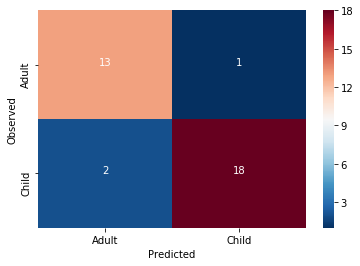

In [56]:
l_svc.fit(X_train_scl, y_train) # fit to training data
y_pred = l_svc.predict(X_test_scl) # classify age class using testing data
acc = l_svc.score(X_test, y_test) # get accuracy
cr = classification_report(y_pred=y_pred, y_true=y_test) # get prec., recall & f1
cm = confusion_matrix(y_pred=y_pred, y_true=y_test) # get confusion matrix

# print results
print('accuracy =', acc)
print(cr)

# plot results
thresh = cm.max() / 2
cmdf = DataFrame(cm, index = ['Adult','Child'], columns = ['Adult','Child'])
sns.heatmap(cmdf, cmap='RdBu_r')
plt.xlabel('Predicted')
plt.ylabel('Observed')
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j+0.5, i+0.5, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white")

***Wow!!*** Congratulations. You just trained a machine learning model that used real rs-fmri data to predict the age of real humans.

It seems like something in this data does seem to be systematically related to age ... but what?  

### Interpreting model feature importances
Interpreting the feature importances of a machine learning model is a real can of worms. This is an area of active research. Unfortunately, it's hard to trust the feature importance of some models. 

You can find a whole tutorial on this subject here:
http://gael-varoquaux.info/interpreting_ml_tuto/index.html

For now, we'll just eschew better judgement and take a look at our feature importances

We can access the feature importances (weights) used my the model

In [57]:
l_svc.coef_

array([[ 3.97279963e-03, -1.53691113e-05, -6.08134592e-03, ...,
        -1.67284545e-03,  9.31604117e-05, -2.47241130e-04]])

lets plot these weights to see their distribution better

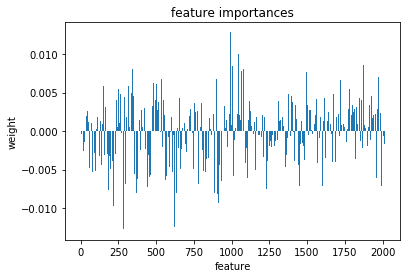

In [58]:
plt.bar(range(l_svc.coef_.shape[-1]),l_svc.coef_[0])
plt.title('feature importances')
plt.xlabel('feature')
plt.ylabel('weight')

Or perhaps it will be easier to visualize this information as a matrix similar to the one we started with

We can use the correlation measure from before to perform an inverse transform

In [59]:
correlation_measure.inverse_transform(l_svc.coef_).shape

(1, 64, 64)

/home/users/jvogel/anaconda2/envs/nilearn_tutorial/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


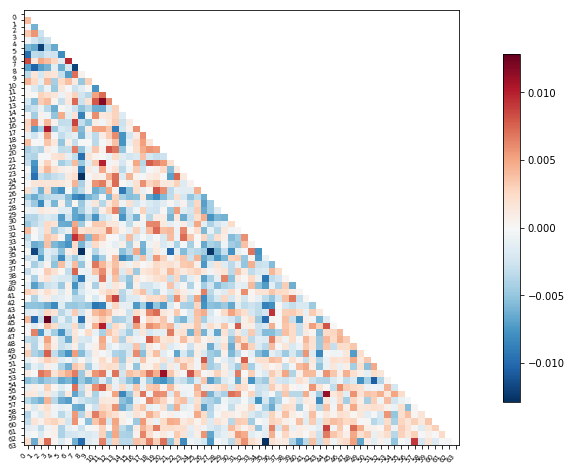

In [60]:
from nilearn import plotting

feat_exp_matrix = correlation_measure.inverse_transform(l_svc.coef_)[0]

plotting.plot_matrix(feat_exp_matrix, figure=(10, 8), 
                     labels=range(feat_exp_matrix.shape[0]),
                     reorder=False,
                    tri='lower')

Let's see if we can throw those features onto an actual brain.

First, we'll need to gather the coordinates of each ROI of our atlas

In [61]:
coords = plotting.find_parcellation_cut_coords(atlas_filename)

And now we can use our feature matrix and the wonders of nilearn to create a connectome map where each node is an ROI, and each connection is weighted by the importance of the feature to the model

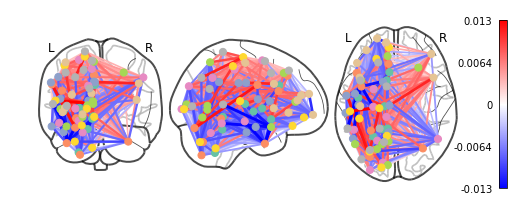

In [62]:
plotting.plot_connectome(feat_exp_matrix, coords, colorbar=True)

Whoa!! That's...a lot to process. Maybe let's threshold the edges so that only the most important connections are visualized

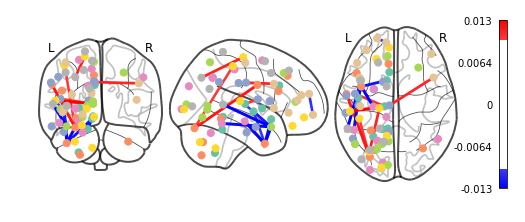

In [65]:
plotting.plot_connectome(feat_exp_matrix, coords, colorbar=True, edge_threshold=0.01)

That's definitely an improvement, but it's still a bit hard to see what's going on.
Nilearn has a new feature that let's use view this data interactively!

In [69]:
view = plotting.view_connectome(feat_exp_matrix, coords, threshold='90%')    
view.open_in_browser() 


/home/users/jvogel/.local/lib/python3.6/site-packages/nibabel/gifti/parse_gifti_fast.py:62: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  newarr = np.fromstring(zdec, dtype=dt)


In [72]:
#view.save_as_html('/home/users/jvogel/NLtest.html')